# Run2019 analysis

* reactor neutrino flux (cite prev paper)
* integrates to give the recoil spectrum (cite prev paper)
* uses (Youssef's) quenching factor to transform into ionization spectrum
* **extraction efficiency converts into observable spectrum**
* **convolution with energy uncertainty to get the measurable spectrum**
* **acceptance(!) to get the final expected spectrum for our selection cuts**

this last step was not performed in my analysis before. I assumed that the selection cuts would only affect with a energy-constant factor --- effective mass of the CCD. However, discussing with Guille, I realized the cuts in the region of interest are not flat and a last **acceptance** step needs to be carefully performed in a similar fashion to the efficiency correction for the extraction.

\begin{equation}
\frac{{\rm d} R }{ {\rm d} E_{\rm M} }
= {\mathcal A}(E_{\rm M})
\int_{-\infty}^{+\infty} {\rm d}E_{\rm I}
G\left(E_{\rm I} - \mu(E_{\rm M}); \sigma(E_{\rm M})\right) \epsilon(E_{\rm I}) \frac{{\rm d} R }{{\rm d} E_{\rm I} },
\end{equation}


In this notebook, the efficiency is computed. Then, the measured neutrino spectrum at CONNIE is computed based on the neutrino spectrum from the reactor. Finally, this is compared to the differential rate measured from the run2019. The result achieved is of a 95% confidence level measured rate 16 times larger than the expected neutrino rate.


## Preamble

```bash
module load py-notebook/6.1.5-gcc-8.3.0-lim66g5
module load softwares/texlive/2017
pip3 install uproot –user
pip3 install uncertainties –user
```

In [6]:
%reload_ext autoreload
%autoreload 2

import sys, os
from glob import glob
from copy import *

from numpy import *
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic, norm, median_abs_deviation
from scipy.integrate import quad

import uproot
from uncertainties import *
from uncertainties import unumpy as un

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({
    "image.origin": 'lower',
    "font.family": "serif",
    "font.size": 12,
    "grid.alpha": .5,
})

def O(*funcs):
    def _f(arg):
        if len(funcs) == 1:
            return funcs[-1]( arg )
        return O( *funcs[:-1] )( funcs[-1]( arg ) )
    return _f


def C(*func):
    def _f(args):
        return [ func(args) for func in funcs ]
    return _f

def mapd( func, d, key=lambda _: _):
    return dict( map( lambda kv: ( key(kv[0]), func(kv[1]) ), d.items() ) )

mad = lambda x, axis=None: median_abs_deviation(x, axis=axis)

arange2 = lambda i,f,s: arange(i,f+s,s)
binCenters = lambda bins: (bins[1:]+bins[:-1])/2.
binErrs = lambda bins: (bins[1:] - bins[:-1])/2.

In [7]:
class Axes:
    def __init__(self, debug=False, xlabel='x', ylabel='y', title=None, 
                 xscale='linear', yscale='linear',
                 xlim=(None,None), ylim=(None,None), **kwargs):
        self.commands = []
        self.kwargs = kwargs
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.xscale = xscale
        self.yscale = yscale
        self.xlim = xlim
        self.ylim = ylim        
        self.title = title
        self.debug = debug
        self.commands.append( lambda ax: ax.set_xlabel(self.xlabel) )
        self.commands.append( lambda ax: ax.set_ylabel(self.ylabel) )
        self.commands.append( lambda ax: ax.grid(which='both') )
        if self.debug: print('init Axes')
    def __enter__(self, **kwargs):
        if self.debug: print('enter Axes')
        return self
    def __exit__(self, type, value, traceback):
        if type:
            print(type)
            print(value)
            print(traceback)
            raise type
        if self.debug: print('exiting Axes')
        self.commands.append( lambda ax: ax.legend(title=self.title) )
        self.commands.append( lambda ax: ax.set_xscale(self.xscale) )
        self.commands.append( lambda ax: ax.set_yscale(self.yscale) )
        self.commands.append( lambda ax: ax.set_xlim(*self.xlim) )
        self.commands.append( lambda ax: ax.set_ylim(*self.ylim) )
        return True
    def __getattr__(self, member):
        if self.debug: print( f'called {member}' )
        def command(*args, **kwargs):
            if self.debug: print( kwargs.keys(), self.kwargs.keys() )
            self.commands.append(
                lambda ax: getattr(ax, member)(
                    *args, **kwargs, **self.kwargs
                )
            )
            if self.debug: print( self.commands )
            return
        return command

class Figure:
    figsize = (12,6)
    number = 0
    def __init__(self, ncols=1, debug=False, **kwargs):
        self.axes = []
        self.ncols = ncols
        self.debug = debug
        if self.debug: print('init Figure')
    def __enter__(self):
        if self.debug: print('enter Figure')
        return self
    def __exit__(self, type, value, traceback):
        if type:
            print(type)
            print(value)
            print(traceback)
            raise type
            
        if self.debug: print( 'number of axes', len(self.axes) )
        nrows = int( len(self.axes)/self.ncols ) + 1
        if self.debug: print( 'nrows', nrows )
        fig = plt.figure(figsize=(
            Figure.figsize[0], 
            Figure.figsize[1]*nrows
        ))
        for i, axis in enumerate(self.axes):
            if self.debug: print('command', i)
            ax = fig.add_subplot(nrows, self.ncols, i+1)
            for command in axis.commands:
                if self.debug: print('command', command)
                command(ax)
        Figure.number += 1
        print(f'Figure [{Figure.number}]')
        plt.show()
        if self.debug: print('exiting Figure')
        return True
    def addAxes(self, **kwargs):
        ax = Axes(debug=self.debug, **kwargs)
        self.axes.append( ax )
        if self.debug: 
            print('number of axes', len(self.axes), kwargs.keys() )
        return ax

In [8]:
class BinnedSpectrum(ndarray):
    def __new__(cls, array, bins):
        obj = asarray(array).view(cls)
        obj.bins = bins
        return obj
        
    def __finalize_array__(self, obj):
        if obj is None: return
        self.bins = obj.bins
    
    def plot(self, ax, **kwargs):
        ax.errorbar( 
            self.binCenters(), 
            y=self.n(), 
            xerr=self.bins[2]/2., 
            yerr=self.s(), 
            fmt=' ', 
            **kwargs 
        )

    def n(self):
        return un.nominal_values(self)
    
    def s(self):
        return un.std_devs(self)
    
    def binEdges(self):
        return arange2(*self.bins)

    def binCenters(self):
        bins = self.binEdges()
        return .5*(bins[1:]+bins[:-1])
    
    def __truediv__(self, a):
        ret = array(self)
        b = array(a)
        ret[b>0] /= b[b>0]
        return BinnedSpectrum(ret, self.bins)
    
    def __add__(self, a):
        print('add')
        return BinnedSpectrum( 
            array(self) + array(a), 
            self.bins
        )

    def __sub__(self, a):
        return BinnedSpectrum( 
            array(self) - array(a), 
            self.bins
        )

    def __mul__(self, a):
        return BinnedSpectrum( array(self) * array(a), self.bins)
        
    def fit_params(self, func, p0):
        popt = curve_fit( func, self.binCenters(), un.nominal_values(self), p0=p0 )[0]
        return popt
    
    def fit_func(self, func, p0):
        return lambda x: func(x, *self.fit_params(func, p0))
    
    def plot_fit(self, ax, func, p0, **kwargs):
        x = self.binCenters()
        ax.plot( x, self.fit_func(func,p0)(x), **kwargs)
    
    def interp(self, **kwargs):
        return interp1d(self.binCenters(), self.n(), bounds_error=False, fill_value='extrapolate', **kwargs)
    
    @classmethod
    def fromCatalogs(cls, pattern, branch, bins, weights=None, cut=None, statistic='count', debug=False, yerrFunc = sqrt):
        values = uproot.concatenate(pattern, expressions=branch, cut=cut, library='np')[branch]
        if debug: print( 'values', values )
        w = ones_like(values)
        if weights:
            w = uproot.concatenate(pattern, expressions=weights, cut=cut, library='np')[weights]
        y = binned_statistic( values, w, bins=arange2(*bins), statistic=statistic )[0].astype(float)
        if statistic == 'mean':
            yerr = binned_statistic( values, w, bins=arange2(*bins), statistic='std' )[0].astype(float)
        else:
            yerr = sqrt(y)
        return BinnedSpectrum( un.uarray(y, yerr), bins )
    
    @classmethod
    def fromFunc(cls, func, bins, epsrel=1e-4):
        x = arange2(*bins)
        y = array( [ quad( func, x[i], x[i+1], epsrel=epsrel )[0]/(x[i+1]-x[i]) 
                         for i in range(len(x)-1) ] )
        return BinnedSpectrum( un.uarray(y, 0), bins )

def printtable( *specs, xlabel='x', ylabels=['y'], fmt='uf' ):
    
    x = list(map(lambda s: f'{s}', specs[0].binEdges()[:-1]))
    xlen = max(map(len, x))

    y = [ list(map(lambda s: ('{:.1%s}'%fmt).format(s), spec)) for spec in specs ]
    ylen = [ max(map(len, _y)) for _y in y ]

    format_str = '{:<%s} | '%xlen
    format_str += ' | '.join( [ '{:<%s}'%_ylen for _ylen in ylen ] )
    
    print( format_str.format(xlabel, *ylabels) )
    print( '='*( xlen + sum(ylen) + 3*len(ylabels) ) )
    x = list(map(lambda s: ('{:>%s}'%(xlen)).format(s), x))
    y = [ list(map(lambda s: ('{:>%s}'%(_ylen)).format(s), _y)) for _y, _ylen in zip(y,ylen) ]

    table = list( zip(x, *y) )
    print( '\n'.join(map(lambda s: ' | '.join(s), table) ) )
    print( '='*( xlen + sum(ylen) + 3*len(ylabels) ) )

def nom( kernel, func, epsrel=1e-2, lims=(0, inf) ):
    return vectorize( lambda new_x: quad( 
        lambda x: kernel(new_x, x)*func(x), lims[0], lims[1], epsrel=epsrel 
    )[0] )

def den( kernel, epsrel=1e-2, lims=(0, inf) ):
    return vectorize( lambda new_x: quad( 
        lambda x: kernel(new_x, x), lims[0], lims[1], epsrel=epsrel 
    )[0] )

def convolveFuncs( kernel, func, epsrel=1e-2, lims=(0, inf) ):
    nomf = nom( kernel, func, epsrel=epsrel, lims=lims )
    denf = den( kernel, epsrel=epsrel, lims=lims)
    return lambda x: nomf(x)/denf(x)

In [9]:
pattern = {
    'match': '/share/storage2/connie/DAna/nuCatalogs/match_*_sim_[6-7]*_to_*_v4.0.root',
    'data': '/share/storage2/connie/DAna/nuCatalogs/shape_*_data_[6-7]*_to_*_v4.0.root',    
    'sim': '/share/storage2/connie/DAna/nuCatalogs/draw_all*.root',
}
OHDUs = [2,3,4,5,8,9,13,14]

In [10]:
class FuncDict:
    def __init__(self, func):
        self.func = func
        self.d = {}
    
    def __getitem__(self, arg):
        if not arg in self.d:
            self.d[arg] = func(arg)
        return self.d[arg]

#### Reactor Flux

In [63]:
table_low_str = """
0.01 {1.5530018562704834*^11}
0.02 {6.005034361588921*^11}
0.03 {1.205167684591993*^12}
0.04 {1.117014841007298*^12}
0.05 {9.343869394201768*^11}
0.06 {7.517590378330554*^11}
0.07 {1.6425852118122908*^12}
0.08 {1.9711246533577*^12}
0.09 {2.3079499233331025*^12}
0.1 {2.648513969728002*^12}
0.11 {2.9219876851879478*^12}
0.12 {2.9533073391204526*^12}
0.13 {2.949830499787536*^12}
0.14 {2.9651714585854453*^12}
0.15 {3.0729146169816865*^12}
0.16 {3.373816011521532*^12}
0.17 {3.6539508075396426*^12}
0.18 {3.9769707715061743*^12}
0.19 {4.2808237124372046*^12}
0.2 {4.488872152984008*^12}
0.21 {4.61950809706516*^12}
0.22 {4.750144041146314*^12}
0.23 {4.9618615161931045*^12}
0.24 {5.219226955375285*^12}
0.25 {5.447135387607598*^12}
0.26 {5.525220546375105*^12}
0.27 {5.603305705142613*^12}
0.28 {5.68139086391012*^12}
0.29 {5.702846563497595*^12}
0.3 {5.648805125951446*^12}
0.31 {5.594763688405299*^12}
0.32 {5.54072225085915*^12}
0.33 {5.529010804165791*^12}
0.34 {5.535277089732321*^12}
0.35000000000000003 {5.541543375298854*^12}
0.36 {5.547809660865384*^12}
0.37 {5.554075946431915*^12}
0.38 {5.497671846049564*^12}
0.39 {5.418427985690482*^12}
0.4 {5.303417806540855*^12}
0.41000000000000003 {5.080693719283203*^12}
0.42 {4.939166894686375*^12}
0.43 {4.773202091786177*^12}
0.44 {4.612116444586013*^12}
0.45 {4.468271184987282*^12}
0.46 {4.3401852498885356*^12}
0.47000000000000003 {4.2298784261141455*^12}
0.48 {4.049308268198851*^12}
0.49 {3.878492288493314*^12}
0.5 {3.742361592881283*^12}
0.51 {3.616792971475971*^12}
0.52 {3.6092658114129204*^12}
0.53 {3.60173865134987*^12}
0.54 {3.6245935185689976*^12}
0.55 {3.665210126617912*^12}
0.56 {3.6983307640206113*^12}
0.5700000000000001 {3.7314514014233115*^12}
0.58 {3.7359298135790073*^12}
0.59 {3.7356328506468535*^12}
0.6 {3.7353358877146997*^12}
0.61 {3.7328256051310923*^12}
0.62 {3.71555533198841*^12}
0.63 {3.698285058845728*^12}
0.64 {3.681014785703045*^12}
0.65 {3.661258544548484*^12}
0.66 {3.637830312496019*^12}
0.67 {3.6144020804435547*^12}
0.68 {3.5993626650557744*^12}
0.6900000000000001 {3.5850596550904253*^12}
0.7000000000000001 {3.5707566451250757*^12}
0.71 {3.560455401410902*^12}
0.72 {3.566940787555557*^12}
0.73 {3.573426173700212*^12}
0.74 {3.5727077844237974*^12}
0.75 {3.569019783446478*^12}
0.76 {3.554209758227955*^12}
0.77 {3.539399733009431*^12}
0.78 {3.524589707790908*^12}
0.79 {3.502878595750244*^12}
0.8 {3.478731421536807*^12}
0.81 {3.4545842473233696*^12}
0.8200000000000001 {3.430698431013084*^12}
0.8300000000000001 {3.4276285070538145*^12}
0.84 {3.4245585830945454*^12}
0.85 {3.421488659135275*^12}
0.86 {3.414821673335469*^12}
0.87 {3.3991614034170264*^12}
0.88 {3.383501133498584*^12}
0.89 {3.367840863580141*^12}
0.9 {3.365570765183135*^12}
0.91 {3.3738642904729873*^12}
0.92 {3.3823053640580684*^12}
0.93 {3.39257940337783*^12}
0.9400000000000001 {3.4028534426975923*^12}
0.9500000000000001 {3.400326427083764*^12}
0.96 {3.3889074399104053*^12}
0.97 {3.3774884527370474*^12}
0.98 {3.366069465563689*^12}
0.99 {3.4105373527211743*^12}
1. {3.4405001047735273*^12}
1.01 {3.4501157106183066*^12}
1.02 {3.4553741008474385*^12}
1.03 {3.43318521314735*^12}
1.04 {3.4109963254472617*^12}
1.05 {3.388807437747174*^12}
1.06 {3.366618550047086*^12}
1.07 {3.343219630257972*^12}
1.08 {3.3138281705993955*^12}
1.09 {3.284436710940819*^12}
1.1 {3.255045251282243*^12}
1.11 {3.2023353325810527*^12}
1.12 {3.1216166732041353*^12}
1.1300000000000001 {3.0471334351222085*^12}
1.1400000000000001 {2.9792255841626597*^12}
1.1500000000000001 {2.915887880772996*^12}
1.16 {2.8567586835787964*^12}
1.17 {2.794583280829742*^12}
1.18 {2.7128612632913438*^12}
1.19 {2.625284667667476*^12}
1.2 {2.576460462557913*^12}
1.21 {2.5366659499147383*^12}
1.22 {2.493357073618325*^12}
1.23 {2.4521148649751797*^12}
1.24 {2.4161623391962837*^12}
1.25 {2.315938444690881*^12}
1.26 {2.2984151285622026*^12}
1.27 {2.2808918124335244*^12}
1.28 {2.2633684963048467*^12}
1.29 {2.2458451801761675*^12}
1.3 {2.2283218640474897*^12}
1.31 {2.2107985479188115*^12}
1.32 {2.1932752317901333*^12}
1.33 {2.175751915661454*^12}
1.34 {2.1582285995327766*^12}
1.35 {2.140705283404098*^12}
1.36 {2.12318196727542*^12}
1.37 {2.1056586511467415*^12}
1.3800000000000001 {2.0881353350180632*^12}
1.3900000000000001 {2.0706120188893848*^12}
1.4000000000000001 {2.0530887027607065*^12}
1.41 {2.0355653866320288*^12}
1.42 {2.0180420705033503*^12}
1.43 {2.0005187543746719*^12}
1.44 {1.9829954382459937*^12}
1.45 {1.9654721221173154*^12}
1.46 {1.9479488059886375*^12}
1.47 {1.9304254898599585*^12}
1.48 {1.9129021737312808*^12}
1.49 {1.8953788576026023*^12}
1.5 {1.877855541473924*^12}
1.51 {1.8682139407331865*^12}
1.52 {1.8585723399924492*^12}
1.53 {1.8489307392517117*^12}
1.54 {1.8392891385109744*^12}
1.55 {1.829647537770237*^12}
1.56 {1.8200059370294995*^12}
1.57 {1.8103643362887622*^12}
1.58 {1.8007227355480251*^12}
1.59 {1.7910811348072876*^12}
1.6 {1.7814395340665498*^12}
1.61 {1.7717979333258127*^12}
1.62 {1.7621563325850752*^12}
1.6300000000000001 {1.7525147318443381*^12}
1.6400000000000001 {1.7428731311036006*^12}
1.6500000000000001 {1.7332315303628633*^12}
1.6600000000000001 {1.7235899296221257*^12}
1.67 {1.713948328881389*^12}
1.68 {1.7043067281406511*^12}
1.69 {1.6946651273999138*^12}
1.7 {1.6850235266591763*^12}
1.71 {1.675381925918439*^12}
1.72 {1.6657403251777017*^12}
1.73 {1.656098724436964*^12}
1.74 {1.646457123696227*^12}
1.75 {1.6368155229554897*^12}
1.76 {1.6271739222147524*^12}
1.77 {1.617532321474015*^12}
1.78 {1.6078907207332776*^12}
1.79 {1.59824911999254*^12}
1.8 {1.588607519251803*^12}
1.81 {1.5789659185110654*^12}
1.82 {1.5693243177703281*^12}
1.83 {1.5596827170295906*^12}
1.84 {1.5500411162888535*^12}
1.85 {1.5403995155481157*^12}
1.86 {1.5307579148073782*^12}
1.87 {1.5211163140666409*^12}
1.8800000000000001 {1.5114747133259036*^12}
1.8900000000000001 {1.5018331125851663*^12}
1.9000000000000001 {1.4921915118444287*^12}
1.9100000000000001 {1.4825499111036914*^12}
1.92 {1.4729083103629543*^12}
1.93 {1.463266709622217*^12}
1.94 {1.4536251088814797*^12}
1.95 {1.4439835081407422*^12}
1.96 {1.434341907400005*^12}
1.97 {1.4247003066592676*^12}
1.98 {1.41505870591853*^12}
1.99 {1.4054171051777927*^12}
2. {1.3957755044370554*^12}"""

table_low = '[' + table_low_str.replace(' {', ',').replace('}\n', '],[').replace('}',']').replace('*^','E')

In [64]:
table_low

'[\n0.01,1.5530018562704834E11],[0.02,6.005034361588921E11],[0.03,1.205167684591993E12],[0.04,1.117014841007298E12],[0.05,9.343869394201768E11],[0.06,7.517590378330554E11],[0.07,1.6425852118122908E12],[0.08,1.9711246533577E12],[0.09,2.3079499233331025E12],[0.1,2.648513969728002E12],[0.11,2.9219876851879478E12],[0.12,2.9533073391204526E12],[0.13,2.949830499787536E12],[0.14,2.9651714585854453E12],[0.15,3.0729146169816865E12],[0.16,3.373816011521532E12],[0.17,3.6539508075396426E12],[0.18,3.9769707715061743E12],[0.19,4.2808237124372046E12],[0.2,4.488872152984008E12],[0.21,4.61950809706516E12],[0.22,4.750144041146314E12],[0.23,4.9618615161931045E12],[0.24,5.219226955375285E12],[0.25,5.447135387607598E12],[0.26,5.525220546375105E12],[0.27,5.603305705142613E12],[0.28,5.68139086391012E12],[0.29,5.702846563497595E12],[0.3,5.648805125951446E12],[0.31,5.594763688405299E12],[0.32,5.54072225085915E12],[0.33,5.529010804165791E12],[0.34,5.535277089732321E12],[0.35000000000000003,5.541543375298854E12]

In [65]:
table_low = eval(table_low)
table_low = array(table_low)

In [66]:
table_low

array([[1.00000000e-02, 1.55300186e+11],
       [2.00000000e-02, 6.00503436e+11],
       [3.00000000e-02, 1.20516768e+12],
       [4.00000000e-02, 1.11701484e+12],
       [5.00000000e-02, 9.34386939e+11],
       [6.00000000e-02, 7.51759038e+11],
       [7.00000000e-02, 1.64258521e+12],
       [8.00000000e-02, 1.97112465e+12],
       [9.00000000e-02, 2.30794992e+12],
       [1.00000000e-01, 2.64851397e+12],
       [1.10000000e-01, 2.92198769e+12],
       [1.20000000e-01, 2.95330734e+12],
       [1.30000000e-01, 2.94983050e+12],
       [1.40000000e-01, 2.96517146e+12],
       [1.50000000e-01, 3.07291462e+12],
       [1.60000000e-01, 3.37381601e+12],
       [1.70000000e-01, 3.65395081e+12],
       [1.80000000e-01, 3.97697077e+12],
       [1.90000000e-01, 4.28082371e+12],
       [2.00000000e-01, 4.48887215e+12],
       [2.10000000e-01, 4.61950810e+12],
       [2.20000000e-01, 4.75014404e+12],
       [2.30000000e-01, 4.96186152e+12],
       [2.40000000e-01, 5.21922696e+12],
       [2.500000

Figure [10]


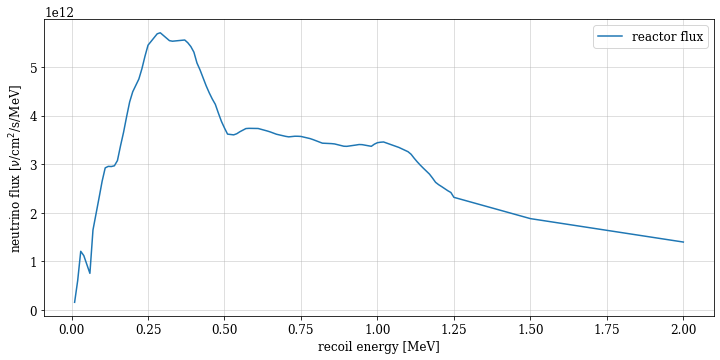

In [71]:
with Figure(ncols=1) as fig:
    with fig.addAxes(xlabel='recoil energy [MeV]', ylabel=r'neutrino flux [$\nu$/cm$^2$/s/MeV]', 
                         xscale='linear', yscale='linear', title=r'') as ax:
            ax.plot(table_low[:,0], table_low[:,1], label=r'reactor flux')

In [74]:
def crossSection(Enu, ER):
    GF = 1.1663787e-5 #1.166 3787 x 10-5 GeV-2
    mU = 931.49410242 #GeV/c²
    M = 28.085*mU
    F = lambda q: 1
    QW = N #nuleons
    return GF**2/(4*pi)*QW**2 * (1 - M*ER/(2*Enu**2) - ER/Enu + ER**2/(2*Enu**2) ) * M*F(q)**2

# Quenching factor
Below we define [Brenda's](https://arxiv.org/pdf/1910.04951) parametrization of Chavarria's the quenching factor
$$
Q(E_{\rm I}) = \frac{ p_3 E_{\rm I} + p_4 E_{\rm I}^2 + E_{\rm I}^3 }{ p_0 + p_1 E_{\rm I} + p_2 E_{\rm I}^2}
$$
where $p = \{50{\rm keV}^3, 1096{\rm keV}^2, 382{\rm keV}, 168{\rm keV}^2, 155{\rm keV}\}$. This is not used for now in the following calculation, since the neutrino spectrum I have is already multiplied by Juan for by the quenching factor used in DAMIC.

In [ ]:
Q = {}
dQ_dE = {}
def Chavarria(E, diff=False):
    p = [ 56, 1096, 382, 168, 155 ]
    E = E/1e3
    num = p[3]*E + p[4]*E**2 + E**3
    den = p[0] + p[1]*E + p[2]*E**2
    if diff:
        dnum = (p[3] + 2*p[4]*E + 3*E**2)/1e3
        dden = (p[1] + 2*p[2]*E)/1e3
        return dnum/den - num/den**2*dden
    return num/den

def constant(E, diff=False):
    k = .305
    if diff:
        return zeros_like(E)
    return k*ones_like(E)

Q['Chavarria'] = Chavarria
dQ_dE['Chavarria'] = lambda E: Chavarria(E, diff=True)
Q['constant'] = constant
dQ_dE['constant'] = lambda E: constant(E, diff=True)


In [ ]:
_E = arange2(10,4000,5)
with Figure(ncols=2) as fig:
    with fig.addAxes(xlabel='ionization energy [eV]', ylabel='quenching factor') as ax:
        ax.plot( _E, Q['Chavarria'](_E), label='Chavarria QF' )
        ax.plot( _E, Q['constant'](_E), label='constant QF' )
    with fig.addAxes(xscale='log', yscale='log', xlabel='ionization energy [eVee]', 
                     ylabel='recoil energy [eV]') as ax:
        ax.plot( _E, _E/Q['Chavarria'](_E), label='Chavarria QF' )
        ax.plot( _E, _E/Q['constant'](_E), label='constant QF' )

Once the recoil neutrino rate is known, it needs to be converted into ionization energy rate. This is achieved by using the quenching factor $Q = E_{\rm I}/E_{\rm R}$. So the ionization neutrino rate can be computed as,
$$
\frac{{\rm d} R}{{\rm d} E_{\rm I} } 
= \frac{{\rm d} R}{{\rm d} E_{\rm R} } \frac{{\rm d} E_{\rm R}}{{\rm d} E_{\rm I} }
= \frac{{\rm d} R}{{\rm d} E_{\rm R} } \frac{1}{Q(E_{\rm I})}\left( 
    1 - \frac{E_{\rm I}}{Q(E_{\rm I})} \frac{{\rm d} Q}{{\rm d} E_{\rm I} } 
\right).
$$

# Neutrino ionization rate

After converting the recoil spectrum to the ionization spectrum using the quenching factor, one gets the ionization rate

$$
\frac{{\rm d}R}{{\rm d}E_I}
$$

In [ ]:
%%bash 
echo "0.010933,73.348
0.013714,81.397
0.016243,88.899
0.018531,97.745
0.020591,108.04
0.022442,120.02
0.024103,133.52
0.025598,148.45
0.026948,164.28
0.028177,176.05
0.029307,190.67
0.030365,199.09
0.031374,206.39
0.032361,205.84
0.033355,200.11
0.034383,189.16
0.035479,173.44
0.036662,158.57
0.037946,145
0.039334,133.15
0.040825,123.73
0.042416,115.05
0.0441,107.83
0.045868,101.68
0.047715,96.499
0.049633,91.762
0.051618,87.71
0.053666,83.983
0.055774,80.312
0.057943,76.987
0.060174,73.605
0.062468,70.497
0.064828,67.298
0.067257,64.3
0.069758,61.268
0.072335,58.419
0.07499,55.552
0.077728,52.763
0.080549,50.235
0.083459,47.6
0.08646,45.164
0.089554,42.792
0.092744,40.641
0.096033,38.459
0.099424,36.359
0.10292,34.359
0.10653,32.441
0.11024,30.616
0.11408,28.932
0.11803,27.269
0.1221,25.697
0.1263,24.185
0.13063,22.739
0.1351,21.358
0.1397,20.081
0.14445,18.833
0.14934,17.629
0.15438,16.513
0.15958,15.455
0.16494,14.445
0.17047,13.508
0.17616,12.591
0.18203,11.735
0.18809,10.918
0.19432,10.159
0.20076,9.4441
0.20739,8.7732
0.21422,8.1308
0.22127,7.5455
0.22853,6.9678
0.23601,6.4462
0.24373,5.946
0.25168,5.4874
0.25988,5.0483
0.26833,4.6479
0.27704,4.2597
0.28602,3.9119
0.29527,3.5788
0.30481,3.2757
0.31464,2.9822
0.32477,2.7234
0.33522,2.4737
0.34599,2.25
0.35708,2.0346
0.36852,1.842
0.3803,1.661
0.39245,1.4958
0.40497,1.3435
0.41788,1.2057
0.43118,1.0759
0.44489,0.9601
0.45903,0.85242
0.47359,0.75662
0.4886,0.66621
0.50407,0.58781
0.52002,0.51449
0.53645,0.44992
0.55339,0.39057
0.57085,0.33872
0.58884,0.29172
0.60739,0.25078
0.6265,0.21319
0.6462,0.18157
0.6665,0.15268
0.68742,0.12821
0.70899,0.10643
0.73122,0.088319
0.75413,0.072061
0.77774,0.058874
0.80207,0.047243
0.82715,0.037948
0.85301,0.029905
0.87965,0.023556
0.90711,0.018166
0.93541,0.014036
0.96458,0.010582
0.99464,0.0080122
1.0256,0.0059098
1.0576,0.0043926
1.0905,0.0031737
1.1244,0.0023203
1.1594,0.0016519
1.1954,0.0011945
1.2326,0.00084415
1.2708,0.00060767
1.3103,0.00042976
1.351,0.000309
1.3929,0.00021894
1.4361,0.00015742
1.4807,0.00011125
1.5266,7.9557e-05
1.5739,5.5535e-05
1.6226,3.9112e-05
1.6729,2.6744e-05
1.7247,1.8436e-05
1.7781,1.2233e-05
1.8332,8.1773e-06
1.8899,5.241e-06
1.9484,3.3818e-06
2.0087,2.0819e-06
2.0709,1.2885e-06
2.1349,7.5818e-07
2.201,4.469e-07
2.269,2.499e-07
2.3392,1.3892e-07
2.4115,7.3057e-08
2.4861,3.7647e-08
2.5629,1.8263e-08
2.6421,8.38e-09
2.7238,3.5193e-09
" > ionSpectrumG.csv

In [ ]:
genfromtxt('ionSpectrumG.csv', delimiter=',').T

In [ ]:
# file='vSpectrum.csv'
def load_nuSpectrum(e, file='ionSpectrumG.csv', delimiter=',', show=True):
    nuSpectrum = interp1d( *genfromtxt(file, delimiter=delimiter).T, 
                    kind='slinear', 
                    bounds_error=False, 
                    fill_value='extrapolate'
                         )
    return lambda x: nuSpectrum(x/1e3)

dR_dE = {}

E = arange(30, 600, 1)

dR_dE['Juan'] = {}
dR_dE['Juan']['I'] = load_nuSpectrum(E)

In [ ]:
# for xscale in ['linear', 'log']:
for xscale in ['linear']:
    with Figure(ncols=1) as fig:
        with fig.addAxes(xlabel='energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                         xscale=xscale, yscale='log', title=r'ionization rate') as ax:
            ax.plot(E, dR_dE['Juan']['I'](E), label=r"Youssef QF")
for xscale in ['log']:
    with Figure(ncols=1) as fig:
        with fig.addAxes(xlabel='energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                         xscale=xscale, yscale='log', title=r'ionization rate') as ax:
            ax.plot(E, dR_dE['Juan']['I'](E), label=r"Youssef QF")


# Extraction efficiency

Perform simulations of neutrino-like events with given ionization energies. Add events to the images and then process it to compute the extraction efficiency.

$$
\epsilon(E_{\rm I}) = \frac{\cal{N}_{\rm R}}{\cal{N}},
$$
where the number of simulated events and the number of reconstructed events are, respectively, given by,
$$
{\cal N} = \frac{{\rm d} N(E_{\rm I})}{{\rm d} E_{\rm I}},
\quad
{\cal N}_{\rm R} = \frac{{\rm d} N_{\rm R}(E_{\rm I})}{{\rm d} E_{\rm I}}.
$$

In [ ]:
matchDistMax=1.5
selection = {}
selection['size'] = '(sizell<.95) & (sizell>0)'
selection['energy'] = '(E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50)'
selection['geom'] = '(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'
# selection['runIDoff'] = '(runID>6226) & (runID<6975)'

selection['sim'] = lambda ohdu: ' & '.join( [f'hdu=={ohdu}'] )
selection['match'] = lambda ohdu: ' & '.join( [
    f'(ohdu=={ohdu}) & (distSim < {matchDistMax})', 
#     selection['runIDoff'],
] )
selection['matchSel'] = lambda ohdu: ' & '.join( [
    f'(ohdu=={ohdu}) & (distSim < {matchDistMax})', 
    selection['size'],
    selection['energy'],
    selection['geom'],
#     selection['runIDoff']
] )


Ebins = (0, 2500, 5)

dN_dE = {}
epsilon = {}
for ohdu in OHDUs:
    dN_dE[ohdu] = {}
    dN_dE[ohdu]['sim'] = BinnedSpectrum.fromCatalogs( f'{pattern["sim"]}:hitSumm', 'oEnergy',
        cut=selection['sim'](ohdu), bins=Ebins )
    dN_dE[ohdu]['match'] = BinnedSpectrum.fromCatalogs( f'{pattern["match"]}:hitSumm', 'oEnergy',
        cut=selection['match'](ohdu), bins=Ebins )
    dN_dE[ohdu]['matchSel'] = BinnedSpectrum.fromCatalogs( f'{pattern["match"]}:hitSumm', 'oEnergy',
        cut=selection['matchSel'](ohdu), bins=Ebins )
    # 
    epsilon[ohdu] = dN_dE[ohdu]['match']/dN_dE[ohdu]['sim']
    epsilon[f'{ohdu}Sel'] = dN_dE[ohdu]['matchSel']/dN_dE[ohdu]['sim']


In [ ]:
# def epsilon_old(E):
#     E = array(E)/1e3
#     ret = zeros_like(E)
#     p = [17.14, 0.1239, 0.7426]
#     # p[2] - ( 1 + exp(p[0]*(E-p[1]) ) )**(-1)
#     ret[E>.064] = p[2] - exp(-p[0]*(E[E>.064]-p[1]) )/( exp(-p[0]*(E[E>.064]-p[1]) ) + 1 )
#     return ret

tanhFit = lambda x, *p: p[2]*(( tanh( (x - p[1])/p[0] ) + 1 )/2)**10
# expmFit = lambda x, *p: - 1/( 1 + exp(1./p[0]*(x - p[1]) ) ) + p[2]


\begin{equation}\label{eq:extrEff}
\epsilon(E_{\rm I}) = a \left(\frac{\tanh( (E_{\rm I} - b)/c ) + 1}{2}\right)^{10}.
\end{equation}


In [ ]:
e = arange2(0, 2500, 10)
colorMost = 'darkorange'
colorLeast = 'royalblue'

with Figure(ncols=1) as fig:
    with fig.addAxes(xlabel=r'$E_{\rm I}$ [eVee]', ylabel=r'$\epsilon(E_{\rm I})$', title='extraction efficiency', xlim=(0,500)) as ax:
        epsilon[2].plot( ax, label='least efficient', color=colorLeast )
        print( epsilon[2].fit_params(tanhFit, p0=[10,10,10] ) )
        epsilon[2].plot_fit(ax, tanhFit, p0=[10,10,10], label=r'', color=colorLeast )

        epsilon[13].plot( ax, label='most efficient', color=colorMost )
        print( epsilon[13].fit_params(tanhFit, p0=[10,10,10] ) )
        epsilon[13].plot_fit(ax, tanhFit, p0=[10,10,10], label=r'', color=colorMost )


The extraction efficiency flattens around 87% because of the occupancy of the background events. Below is the table of parameters for each CCD. 

In [ ]:
for ohdu in [2,3,4,5,8,9,13,14]:
    dN_dE[ohdu] = {}
    dN_dE[ohdu]['sim'] = BinnedSpectrum.fromCatalogs(
        f'{pattern["sim"]}:hitSumm', 
        'oEnergy', 
        cut=selection['sim'](ohdu), 
        bins=Ebins 
    )
    dN_dE[ohdu]['match'] = BinnedSpectrum.fromCatalogs( 
        f'{pattern["match"]}:hitSumm', 
        'oEnergy',
        cut=selection['match'](ohdu), 
        bins=Ebins 
    )

    print(f'OHDU{ohdu}')
    print( (dN_dE[ohdu]['match']/dN_dE[ohdu]['sim']).fit_params(
        tanhFit, [10,10,10]
    ))            

In [ ]:
with Figure(ncols=1) as fig:
    with fig.addAxes(title='fit tanh', 
                     xlabel='simulated energy [eVee]', 
                     ylabel='efficiency', 
                     xlim=(0,500), ylim=(0,1)) as ax:
        for ohdu in [2,13]:
            dN_dE[ohdu] = {}
            dN_dE[ohdu]['sim'] = BinnedSpectrum.fromCatalogs(
                f'{pattern["sim"]}:hitSumm', 
                'oEnergy', 
                cut=selection['sim'](ohdu), 
                bins=Ebins 
            )
            dN_dE[ohdu]['match'] = BinnedSpectrum.fromCatalogs( 
                f'{pattern["match"]}:hitSumm', 
                'oEnergy',
                cut=selection['match'](ohdu), 
                bins=Ebins 
            )

            (dN_dE[ohdu]['match']/dN_dE[ohdu]['sim']).plot_fit(
                ax, tanhFit, [10,10,10], label=f'OHDU{ohdu}'
            )

# extracted ionization rate

The ionization neutrino rate is then be corrected by the efficiency of reconstruction for each of the ionization energies computed above from the simulations,
$$
\frac{{\rm d} R'}{{\rm d} E_{\rm I} } = \epsilon(E_{\rm I}) \frac{{\rm d} R}{{\rm d} E_{\rm I} }.
$$

In [ ]:
dR_dE['1x5'] = {}
dR_dE['1x1'] = {}
dR_dE['1x5']['I*'] = lambda ohdu, E: epsilon[ohdu].fit_func(tanhFit, p0=[10,10,10])(E)*dR_dE['Juan']['I'](E)

E = arange(30, 600, 1)
with Figure(ncols=1) as fig:
    with fig.addAxes(xlabel='energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                     title='extracted spectrum', ylim=(0,50)) as ax:
        ax.plot( E, dR_dE['1x5']['I*'](2, E), label=r'least efficient', c=colorLeast)
        ax.plot( E, dR_dE['1x5']['I*'](13, E), label=r'most efficient', c=colorMost)
    

# measured energy

the measured energy is not the same as the ionization energy due to the extraction algorithm and the dark current that accumulates in each track.

### mean energy shift

In [ ]:
dispersion = lambda ohdu: uproot.concatenate(f'{pattern["match"]}:hitSumm', expressions=['E1/gain3Peaks*1e3', 'oEnergy'], cut=f'(ohdu=={ohdu}) & (distSim<1.5)', library='np')

with Figure() as fig:
    with fig.addAxes(ylabel='mean ionization energy [eVee]', xlabel='measured energy [eVee]', title=r'$\mu(E_{\rm M})$', xlim=(0,200), ylim=(0,200)) as ax:
        ax.scatter( dispersion(2)['E1/gain3Peaks*1e3'], dispersion(2)['oEnergy'], s=1 )

\begin{equation}\label{eq:muFit}
\mu(E_{\rm M}) = a \frac{ (E_{\rm M} + d )^2 + c }{ E_{\rm M} + b }
\end{equation}


In [2]:
mu = {}
mu['M'] = {}
mu_M = lambda ohdu: BinnedSpectrum.fromCatalogs(f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3', (0, 600, 10), 
                         weights='oEnergy', cut=f'(ohdu=={ohdu}) & (distSim<1.5)', statistic='mean' )
for ohdu in OHDUs:
    mu['M'][ohdu] = mu_M(ohdu)

mufit_func = lambda x, *p: p[0]*((x-p[3])**2 + p[1])/(x + p[2])
mu_p0 = [1,1,1,1]
with Figure() as fig:
    with fig.addAxes(ylabel='mean ionization energy [eVee]', xlabel='measured energy [eVee]', title=r'$\mu(E_{\rm M})$', xlim=(0,200), ylim=(0,200)) as ax:
        mu['M'][2].plot(ax, label=r'least efficient', color=colorLeast)
        mu['M'][13].plot(ax, label=r'most efficient', color=colorMost)        
#         print( mu['M'][2].fit_params(mufit_func, p0=mu_p0) )
        mu['M'][2].plot_fit(ax, mufit_func, p0=mu_p0, label=r'', color=colorLeast)
#         print( mu['M'][13].fit_params(mufit_func, p0=mu_p0) )
        mu['M'][13].plot_fit(ax, mufit_func, p0=mu_p0, label=r'', color=colorMost)

for ohdu in OHDUs:
    print( mu['M'][ohdu].fit_params(mufit_func, p0=mu_p0) )
    
# with Figure() as fig:
#     with fig.addAxes(ylabel='mean ionization energy [eVee]', xlabel='measured energy [eVee]', title=r'$\mu(E_{\rm M})$', xlim=(0,200), ylim=(0,200)) as ax:
#         for ohdu in [2,3,4,5,8,9,13,14]:
#             mu['M'][ohdu].plot(ax, label=f'ohdu{ohdu}')
#             mu['M'][ohdu].plot_fit(ax, mufit_func, p0=mu_p0, label=r'')


NameError: name 'OHDUs' is not defined

### energy dispersion

\begin{equation}\label{eq:sigmaFit}
\sigma( E_{\rm M} ) = a \log\left( \frac{E_{\rm M}-c}{b} \right)
\end{equation}


In [ ]:
sigma = {}
sigma['M'] = {}
sigma_M = lambda ohdu: BinnedSpectrum.fromCatalogs(f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3', (0, 600, 10), 
                         weights='oEnergy', cut=f'(ohdu=={ohdu}) & (distSim<1.5)', statistic='std', yerrFunc = lambda x: 0 )
for ohdu in OHDUs:
    sigma['M'][ohdu] = sigma_M(ohdu)

sigmafit_func = lambda x, *p: p[0]*log((x-p[2])/p[1])
sigma_p0 = [1,1,0]

with Figure() as fig:
    with fig.addAxes(ylabel='dispersion in ionization energy [eVee]', xlabel='measured energy [eVee]', title=r'$\sigma(E_{\rm M})$') as ax:
        sigma['M'][2].plot(ax, label=r'least efficient', color=colorLeast)
        sigma['M'][13].plot(ax, label=r'most efficient', color=colorMost)
        print( sigma['M'][2].fit_params(sigmafit_func, p0=sigma_p0) )
        sigma['M'][2].plot_fit(ax, sigmafit_func, p0=sigma_p0, label=r'', color=colorLeast)
        print( sigma['M'][13].fit_params(sigmafit_func, p0=sigma_p0) )
        sigma['M'][13].plot_fit(ax, sigmafit_func, p0=sigma_p0, label=r'', color=colorMost)

for ohdu in OHDUs:
    print( sigma['M'][ohdu].fit_params(sigmafit_func, p0=sigma_p0) )
    
# with Figure() as fig:
#     with fig.addAxes(ylabel='dispersion in ionization energy [eVee]', xlabel='measured energy [eVee]', title=r'$\sigma(E_{\rm M})$') as ax:
#         for ohdu in OHDUs:
#             sigma['M'][ohdu].plot(ax, label=f'ohdu{ohdu}')
#             sigma['M'][ohdu].plot_fit(ax, sigmafit_func, p0=sigma_p0, label=r'')


# Rate in measured energy

Now the rate is converted to the measured energy by convolving the rate with a gaussian distribution for each measured energy bin.

<!-- $$
\frac{{\rm d} R'(E_{\rm M})}{{\rm d} E_{\rm M} } = 
\frac{1}{W(E_{\rm M})}
\int_{0}^\infty {\rm d}E_{\rm I}\,G \left( E_{\rm I} - \mu(E_{\rm M}); \sigma(E_{\rm M}) \right) \frac{{\rm d} R'(E_{\rm I})}{{\rm d} E_{\rm I} },
$$
 -->
$$
\frac{{\rm d} R'(E_{\rm M})}{{\rm d} E_{\rm M} } = 
\int_{-\infty}^\infty {\rm d}E_{\rm I}\,G \left( E_{\rm I} - \mu(E_{\rm M}); \sigma(E_{\rm M}) \right) \frac{{\rm d} R'(E_{\rm I})}{{\rm d} E_{\rm I} },
$$

<!-- where the normalization is,

$$
W(E_{\rm M}) = \int_0^\infty {\rm d}E_{\rm I}\,G \left( E_{\rm I} - \mu(E_{\rm M}); \sigma(E_{\rm M}) \right).
$$
 -->
it is important that the gaussian parameters do not depend in the integrand ─ the ionization energy ─ to assure it is a gaussian convolution.

In [ ]:
kernel = lambda ohdu, E_new, E: norm.pdf(E, loc=mu['M'][ohdu].interp()(E_new), scale=sigma['M'][ohdu].interp()(E_new) )

E = arange(30, 600, 10)
dR_dE['1x5']['M'] = {}
dR_dE['1x5']['M'][2] = interp1d( E, convolveFuncs( 
    lambda e, ee: kernel(2, e, ee), lambda e: dR_dE['1x5']['I*'](2, e), lims=(30,600)
)(E))
dR_dE['1x5']['M'][13] = interp1d( E, convolveFuncs(
    lambda e, ee: kernel(13, e, ee), lambda e: dR_dE['1x5']['I*'](13, e), lims=(30,600)
)(E))

In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['linear']:#, 'log']:
        with fig.addAxes(xlabel='energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                         title='measured energy', ylim=(0,50), yscale=yscale) as ax:
            ax.plot( E, dR_dE['1x5']['I*'](2, E), label=r'ionization', color=colorLeast )
            ax.plot( E, dR_dE['1x5']['M'][2](E), label=r'measured', color=colorLeast)
            ax.plot( E, dR_dE['1x5']['I*'](13, E), label=r'ionization', color=colorMost)
            ax.plot( E, dR_dE['1x5']['M'][13](E), label=r'measured', color=colorMost)


In [ ]:
mu_fit = {}
for ohdu in OHDUs:
    mu_fit[ohdu] = mu['M'][ohdu].fit_func(mufit_func, p0=mu_p0)

sigma_fit = {}
for ohdu in OHDUs:
    sigma_fit[ohdu] = sigma['M'][ohdu].fit_func(sigmafit_func, p0=sigma_p0)

kernel_fit = {}
for ohdu in OHDUs:
    kernel_fit[ohdu] = lambda e_new, e: norm.pdf(e, loc=mu_fit[ohdu](e_new), scale=sigma_fit[ohdu](e_new) )

E = arange(30, 600, 10)
dR_dE['1x5fit'] = {}
dR_dE['1x5fit']['M'] = {}
for ohdu in OHDUs:
    dR_dE['1x5fit']['M'][ohdu] = interp1d( E, convolveFuncs( 
        kernel_fit[ohdu], lambda e: dR_dE['1x5']['I*'](ohdu, e), lims=(30,600)
    )(E))


In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['linear']:#, 'log']:
        with fig.addAxes(xlabel='energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                         title='measured energy', ylim=(0,50), yscale=yscale) as ax:
            ax.plot( E, dR_dE['1x5']['I*'](2, E), label=r'', ls='--', color=colorLeast )
            ax.plot( E, dR_dE['1x5fit']['M'][2](E), label=r'least efficient', color=colorLeast)
            ax.plot( E, dR_dE['1x5']['I*'](13, E), label=r'', ls='--', color=colorMost)
            ax.plot( E, dR_dE['1x5fit']['M'][13](E), label=r'most efficient', color=colorMost)


# acceptance

the rates in measured energy need to be converted to what is actually measured in our experiment in order to compare to data. Therefore, the acceptance ─ from the selection cuts ─ need to be taken into account. 

\begin{equation}\label{eq:acceptance}
    \mathcal{A}(E_{\rm M})
    =
    \frac{a_2 E_{\rm M}^2 + a_1 E_{\rm M} + a_0 }{ E_{\rm M}^2 + b_1 E_{\rm M} + b_0 }
\end{equation}


In [ ]:
matchDistMax=1.5
selection = {}
selection['size'] = '(sizell<.95) & (sizell>0)'
selection['energy'] = '(E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50)'
selection['geom'] = '(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'
# selection['runIDoff'] = '(runID>6226) & (runID<6975)'

selection['sim'] = lambda ohdu: ' & '.join( [f'hdu=={ohdu}'] )
selection['match'] = lambda ohdu: ' & '.join( [
    f'(ohdu=={ohdu}) & (distSim < {matchDistMax})', 
#     selection['runIDoff'],
] )
selection['matchSel'] = lambda ohdu: ' & '.join( [
    f'(ohdu=={ohdu}) & (distSim < {matchDistMax})', 
    selection['size'],
    selection['energy'],
    selection['geom'],
#     selection['runIDoff']
] )


Ebins = (50, 2500, 5)

dN_dE_M = {}
acceptance = {}
for ohdu in OHDUs:
    dN_dE_M[ohdu] = {}
#     dN_dE_M[ohdu]['sim'] = BinnedSpectrum.fromCatalogs( f'{pattern["sim"]}:hitSumm', 'oEnergy',
#         cut=selection['sim'](ohdu), bins=Ebins )
    dN_dE_M[ohdu]['match'] = BinnedSpectrum.fromCatalogs( f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3',
        cut=selection['match'](ohdu), bins=Ebins )
    dN_dE_M[ohdu]['matchSel'] = BinnedSpectrum.fromCatalogs( f'{pattern["match"]}:hitSumm', 'E1/gain3Peaks*1e3',
        cut=selection['matchSel'](ohdu), bins=Ebins )
    # 
    acceptance[ohdu] = dN_dE_M[ohdu]['matchSel']/dN_dE_M[ohdu]['match']


In [ ]:
e = arange2(0, 2500, 10)

# acceptance_fit = lambda x, *p: p[0] *( 
#     ((tanh( (x-p[1])/p[2] ) + 1)/2)**10
# )
acceptance_fit = lambda x, *p: ( 
    (p[0]*x**2 + p[1]*x + p[2])/(x**2 + p[3]*x + p[4])
)
p0 = [1, 1, 1, 1, 1] #, 100, 100, 
      #1]

for ohdu in OHDUs:
    print( 
        ohdu, '&',
        ' & '.join(map( lambda line: '%f'%line,
            acceptance[ohdu].fit_params( acceptance_fit, p0=p0 ) 
        ))
    )

with Figure(ncols=1) as fig:
    with fig.addAxes(xlabel='energy [eVee]', ylabel='acceptance', title='acceptance', xlim=(50,500)) as ax:
        acceptance[2].plot( ax, label='least efficient', color=colorLeast )
        acceptance[2].plot_fit( ax, acceptance_fit, p0=p0, label=r'', color=colorLeast )
#         for e, i in zip(acceptance[2].binCenters(), acceptance[2]):
#             print( e, i.n )
        
        acceptance[13].plot( ax, label='most efficient', color=colorMost )
        acceptance[13].plot_fit( ax, acceptance_fit, p0=p0, label=r'', color=colorMost )


this means that around 30% of the active area of the CCD is excluded by our selection cuts. And it is also explicit that this effect is not constant in energy for the region of interest

In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['linear']:
        with fig.addAxes(xlabel='energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                         title='acceptance correction', xlim=(50,500), ylim=(0,40), yscale=yscale) as ax:


            ax.plot( E, dR_dE['1x5fit']['M'][2](E), label=r'', color=colorLeast, ls='--')
            ax.plot( E, dR_dE['1x5fit']['M'][2](E)*acceptance[2].fit_func(acceptance_fit, p0=p0)(E), label=r'least efficient', color=colorLeast)

            ax.plot( E, dR_dE['1x5fit']['M'][13](E), label=r'', color=colorMost, ls='--')
            ax.plot( E, dR_dE['1x5fit']['M'][13](E)*acceptance[13].fit_func(acceptance_fit, p0=p0)(E), label=r'most efficient', color=colorMost)

            

In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['log']:
        with fig.addAxes(xlabel=r'$E_{\rm M}$ [eVee]', ylabel=r'$dR/dE_{\rm M}$ [events/kg/day/keV]', 
                         title='expected rate', xlim=(50, 400), ylim=(1, 100), yscale=yscale) as ax:


#             ax.plot( E, dR_dE['1x5fit']['M'][2](E), label=r'', color=colorLeast, ls='--')
            ax.plot( E, dR_dE['1x5fit']['M'][2](E)*acceptance[2].fit_func(acceptance_fit, p0=p0)(E), label=r'least efficient', color=colorLeast)

#             ax.plot( E, dR_dE['1x5fit']['M'][13](E), label=r'', color=colorMost, ls='--')
            ax.plot( E, dR_dE['1x5fit']['M'][13](E)*acceptance[13].fit_func(acceptance_fit, p0=p0)(E), label=r'most efficient', color=colorMost)

            

In [ ]:
with Figure(ncols=1) as fig:
    for yscale in ['log']:
        with fig.addAxes(xlabel=r'$E_{\rm M}$ [eVee]', ylabel=r'$dR/dE_{\rm M}$ [events/kg/day/keV]', 
                         title='expected rate', xlim=(50, 400), ylim=(1, 100), yscale=yscale) as ax:

            average_dR_dE = mean( [ dR_dE['1x5fit']['M'][ohdu](E)*acceptance[ohdu].fit_func(acceptance_fit, p0=p0)(E) for ohdu in OHDUs ], axis=0 )
            ax.plot( E, average_dR_dE, label=r'least efficient', color=colorLeast )
            

# binning

The rate is integrated into bins for 

In [ ]:
# for binsize in [200, 130, 50]:
for binsize in [130]:
    bins = (50, 430, binsize)
    with Figure(ncols=1) as fig:
        for yscale in ['linear']:
            with fig.addAxes(xlabel='measured energy [eVee]', ylabel='rate [events/kg/day/keV]', 
                             title=fr'expected $\nu$ rate\n $\Delta E={binsize}$eV', yscale=yscale, ylim=(0,30)) as ax:
                
                ax.plot( E, dR_dE['1x5fit']['M'][2](E)*acceptance[2].fit_func(acceptance_fit, p0=p0)(E), label=r'', color=colorLeast)
                r2 = BinnedSpectrum.fromFunc(
                    lambda e: dR_dE['1x5fit']['M'][2](e)*acceptance[2].fit_func(acceptance_fit, p0=p0)(e)
                    , bins )
                r2.plot(ax, label=f'least efficient', color=colorLeast)
                print( r2 )

                ax.plot( E, dR_dE['1x5fit']['M'][13](E)*acceptance[13].fit_func(acceptance_fit, p0=p0)(E), label=r'', color=colorMost)
                r13 = BinnedSpectrum.fromFunc(
                    lambda e: dR_dE['1x5fit']['M'][13](e)*acceptance[13].fit_func(acceptance_fit, p0=p0)(e)
                    , bins )
                r13.plot(ax, label=f'most efficient', color=colorMost)
            
        printtable(r2, r13, xlabel='E', ylabels=['eff-', 'eff+'], fmt='f')


# ON–OFF 2019

In this section, the reactor ON and OFF data are selected using the agreed runID, geometric, energy and event-size selection cuts. These are defined below.

### selection cuts

In [3]:
runIDexcluded = [6415, 6475, 6499, 6926, 6927, 6031, 6093, 6096, 6139, 7074, 7222, 7226, 7374]
selection = {}
selection['runID'] = ' & '.join(map(lambda s: f'(runID!={s})', runIDexcluded))

selection['size'] = '(sizell<.95) & (sizell>0)'
selection['energy'] = '(E0/gain3Peaks*1e3>45) & (E1/gain3Peaks*1e3>50)'
selection['geom'] = '(xMin>140) & (xMax<3960) & (yMin>75) & (yMax<898) & (flag==0) & (hPixFlag==0)'
selection['ohdu'] = '(' + ' | '.join(map(lambda s: f'(ohdu=={s})', [2,3,4,5,8,9,13,14])) + ')'

selection['runIDon'] = '( ((runID>6030) & (runID<6227)) | ((runID>6974) & (runID<7522)) )'
selection['runIDoff'] = '(runID>6226) & (runID<6975)'


In [4]:

selection['on'] = lambda ohdu: ' & '.join( [
    selection['runID'], 
    selection['size'], 
    selection['energy'], 
    selection['geom'],
    selection['ohdu'],
    selection['runIDon'],
    f'(ohdu=={ohdu})'
] )
selection['off'] = lambda ohdu: ' & '.join( [
    selection['runID'], 
    selection['size'], 
    selection['energy'], 
    selection['geom'],
    selection['ohdu'],
    selection['runIDoff'],
    f'(ohdu=={ohdu})'
] )

In [5]:
dN_dE['on'] = {}
dN_dE['off'] = {}
Ebins = (50, 9200, 130)
dN_dE['on'][3] = BinnedSpectrum.fromCatalogs(
    f'{pattern["data"]}:hitSumm', 'E1/gain3Peaks*1e3', cut=selection['on'](3), bins=Ebins
)
dN_dE['off'][3] = BinnedSpectrum.fromCatalogs(
    f'{pattern["data"]}:hitSumm', 'E1/gain3Peaks*1e3', cut=selection['off'](3), bins=Ebins
)

nImages = {}
nImages['on'] = unique(uproot.concatenate(
    f'{pattern["data"]}:hitSumm', 'runID', library='np', cut=selection['on'](3)
)['runID'])
nImages['off'] = unique(uproot.concatenate(
    f'{pattern["data"]}:hitSumm', 'runID', library='np', cut=selection['off'](3)
)['runID'])

NameError: name 'dN_dE' is not defined

### convert to rate (mass and exposure)

In [ ]:
dT = {}
rho = 2.42*1e-3*(1e2)**3 #kg/m^3
dM = rho * (15*1e-6)**2 * 675*1e-6 * 4120**2
print('mass', dM, dM*len(OHDUs), len(OHDUs))
dT['on'] = len(nImages['on'])/24
print( 'days on', dT['on'] )
dT['off'] = len(nImages['off'])/24
print( 'days off', dT['off'] )

In [ ]:
dR_dE['on'] = {}
dR_dE['off'] = {}

for ohdu in OHDUs:
    dN_dE['on'][ohdu] = BinnedSpectrum.fromCatalogs(
        f'{pattern["data"]}:hitSumm', 
        'E1/gain3Peaks*1e3', 
        cut=selection['on'](ohdu), 
        bins=Ebins
    )
    dN_dE['off'][ohdu] = BinnedSpectrum.fromCatalogs(
        f'{pattern["data"]}:hitSumm', 
        'E1/gain3Peaks*1e3', 
        cut=selection['off'](ohdu), 
        bins=Ebins
    )
    
    dR_dE['on'][ohdu] = dN_dE['on'][ohdu]/dT['on']/dM/(1e-3*Ebins[-1])
    dR_dE['off'][ohdu] = dN_dE['off'][ohdu]/dT['off']/dM/(1e-3*Ebins[-1])
    
def bmean( args, axis=None ):
    bins = args[0].bins
    m = mean( list(map(array, args)), axis=axis )
    return BinnedSpectrum(m, bins)

def baverage( args, axis=None, return_weights=False, weights=None ):
    bins = args[0].bins
    if weights is None:
        stds = array(list(map(lambda x: array(x.s()), args)))
        weights = 1./stds**2
        weights = weights
    values = array(list(map(array, args)))
    ave = sum( weights*values, axis=axis)/sum(weights, axis=axis)
    if return_weights:
        return BinnedSpectrum(ave, bins), weights
    return BinnedSpectrum(ave, bins)


In [ ]:
with Figure(ncols=1) as fig:
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title='measured rates'
    ) as ax:
        baverage(
            [ dR_dE['on'][ohdu] for ohdu in OHDUs ], 
            axis=0
        ).plot(ax, label='ON')
        baverage(
            [ dR_dE['off'][ohdu] for ohdu in OHDUs ], 
            axis=0
        ).plot(ax, label='OFF')


At this point, all the OHDU rates are generated and shown below.

In [ ]:
with Figure(ncols=2) as fig:
    for ohdu in OHDUs:
        with fig.addAxes(
            xlabel='measured energy [eVee]', 
            ylabel='rate [events/kg/day/keV]',
            title=f'OHDU{ohdu}'
        ) as ax:
            diff = dR_dE['on'][ohdu] - dR_dE['off'][ohdu]
            diff.plot(ax, label=r'ON–OFF')


The combined differential rate is obtained by taking the weighted average of all the OHDUs. For comparison, the mean is also computed.

In [ ]:
aveDiff, weights = baverage(
    [ dR_dE['on'][ohdu] - dR_dE['off'][ohdu] for ohdu in OHDUs ], 
    axis=0,
    return_weights=True
#     extras = [ 
#         BinnedSpectrum.fromFunc(
#             lambda e: dR_dE['1x5fit']['M'][ohdu](e)*acceptance[ohdu].fit_func(acceptance_fit, p0=p0)(e), new_bins 
#         ) for ohdu in [2,3,4,5,8,9,13,14] 
#     ], 
)
print( weights.shape )

new_bins = list(aveDiff.bins)
new_bins[1] = 400
binnedRate = {}
for ohdu in OHDUs:
    binnedRate[ohdu] = BinnedSpectrum.fromFunc(
        lambda e: dR_dE['1x5fit']['M'][ohdu](e)*acceptance[ohdu].fit_func(acceptance_fit, p0=p0)(e), 
        new_bins )

binnedRateAve = baverage(
    [ binnedRate[ohdu] for ohdu in OHDUs ],
    axis=0,
    weights=weights[:,:3]
)

Below, the combined differential rate is compared with the expected neutrino rate obtained in the previous section. At the bottom, the 95% confidence level rate is shown also.

# differential rate

In [ ]:
oneSideCL = 1.64
aveDiff95CF = BinnedSpectrum( array(aveDiff.n()) + oneSideCL*array(aveDiff.s()), aveDiff.bins )

with Figure() as fig:
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'differential rate'
    ) as ax:
        aveDiff.plot(ax, label=r'ON ─ OFF')
#         binnedRate2.plot(ax, label='Juan2')
#         binnedRate13.plot(ax, label='Juan13')
#     with fig.addAxes(
#         xlabel='measured energy [eVee]', 
#         ylabel='rate [events/kg/day/keV]',
#         title=f'OHDU{ohdu}\n95% CF'
#     ) as ax:
#         aveDiff95CF.plot(ax, label=r'ON–OFF weightd')
#         binnedRate2.plot(ax, label='Juan2')
#         binnedRate13.plot(ax, label='Juan13')
with Figure() as fig:
    with fig.addAxes(
        xlabel='measured energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'differential rate\n95% CF',
        xlim=(0,400),
        ylim=(0,1000)
    ) as ax:
        aveDiff95CF.plot(ax, label=r'ON ─ OFF')
        binnedRate[2].plot(ax, label='least efficient')
        binnedRate[13].plot(ax, label='most efficient')


In blue, the mean differential rates. In orange, the weighted averages and in green the expected rates.

Below, the table with the values are presented for the energy range of interest. Also, the ratio between the 95% confidence level of the measurement and the expected rate. The 95% CF level measument is 16 times larger than the expected rate. This is a significant increase in comparison with the 40 times result achieved in the previous paper.

# comparison with expected rate

In [ ]:
# meanDiff95CF3 = BinnedSpectrum( meanDiff95CF[:3], binnedRate.bins )
aveDiff95CF3 = BinnedSpectrum( aveDiff95CF[:3], binnedRate2.bins )

binnedRate_2 = BinnedSpectrum( array(binnedRate[2].n()), binnedRate[2].bins )
binnedRate_13 = BinnedSpectrum( array(binnedRate[13].n()), binnedRate[13].bins )
binnedRate_Ave = BinnedSpectrum( array(binnedRateAve.n()), binnedRateAve.bins )
printtable( 
    aveDiff95CF3, 
    binnedRate_2, 
    binnedRate_13,
    binnedRate_Ave,
#     aveDiff95CF3/binnedRate_2, 
#     aveDiff95CF3/binnedRate_13, 
    xlabel='E', 
    ylabels=['95%CF', 'rate2', 'rate13', 'rateAve'#'ratio2', 'ratio13'
            ], 
    fmt='f' 
)

with Figure(ncols=1) as fig:
    with fig.addAxes(
        xlabel='energy [eVee]', 
        ylabel='rate [events/kg/day/keV]',
        title=f'95% CL',
        yscale='log'
    ) as ax:
        aveDiff95CF3.plot(ax, label=r'ON–OFF')
#         binnedRate[2].plot(ax, label='rate2')
#         binnedRate[13].plot(ax, label='rate13')
        binnedRateAve.plot(ax, label='expected rate')



In [ ]:
print( aveDiff95CF3 )